<a href="https://colab.research.google.com/github/vitroid/TileCycles/blob/main/TileCycles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# install genice to generate the structure of ice.
! pip install genice2

     |████████████████████████████████| 696kB 5.5MB/s 
  Created wheel for genice2: filename=GenIce2-2.1b3-py2.py3-none-any.whl size=836944 sha256=f783af608bb2be10b19724097893170adec6dd4e57fa94d9897511b25c3f939c
  Stored in directory: /root/.cache/pip/wheels/b2/c4/db/0ae48f964fbb8179e85be5292912d1a491f8f35f5560d1d1a5
  Created wheel for pairlist: filename=PairList-0.2.11.1-cp37-cp37m-linux_x86_64.whl size=35272 sha256=721d813ae4f22138d5f8c92f6403dd1f8adbcdd7af61790ea39e93853c1a7432
  Stored in directory: /root/.cache/pip/wheels/74/20/2f/64c940bb1f1046f7859faad73d7ea02597b5f224153795e2d1
  Created wheel for methodtools: filename=methodtools-0.4.2-cp37-none-any.whl size=2986 sha256=979da1ec92e8ce367433b3046ce187d1107ad8647b43f9597c5d7fd64d9e5132
  Stored in directory: /root/.cache/pip/wheels/94/6a/63/a364e72d0abc8869f68b3fd19d701b428b9a0d2579d06f78ae
  Created wheel for wirerope: filename=wirerope-0.4.2-cp37-none-any.whl size=8749 sha256=8a98fe70c8935fa3f216009f5bf12eff16fb2a15dbdaae969e

## benchmark test

In [14]:
from genice2.genice import GenIce
from genice2.plugin import Lattice, Format, Molecule

import networkx as nx
import numpy as np
import random
import time


# sampling parameters for benchmarking
# Accurate
maxRepeat = 100  # loops
maxAccum  = 25   # sec
maxProc   = 100  # sec
maxNode   = 1000000

# Rough estimate
# maxRepeat = 10  # loops
# maxAccum  = 5   # sec
# maxProc   = 10  # sec
# maxNode   = 100000

In [3]:
def test_icerule(d, N):
    assert d.number_of_nodes() == N
    for node in d:
        assert d.in_degree(node) == 2
        assert d.in_degree(node) == 2        

## Buch's algorithm

There are two hydrogen sites between two neighboring oxygens, and Buch's algorithm assumes that the initial configuration is one in which all the hydrogens randomly occupy one of the two sites.

In the initial configuration, there are many oxygen atoms with excess hydrogen. The algorithm migrates hydrogen from such an oxygen atom to a neighboring oxygen atom, and repeats the process randomly until there are two hydrogen species in every oxygen atom.


In [20]:
def migrate(d, excess):
    """
    excess is a set of nodes having more than two outgoing edges
    """
    while len(excess) > 0:
        # random choice from candidates;
        # there may be faster ways
        head = random.choice(list(excess))
        nexts = list(d.successors(head))
        next = random.choice(nexts)
        d.remove_edge(head, next)
        d.add_edge(next, head)
        # if head's outgoing order was three
        if len(nexts) == 3:
            # remove from the excess list
            excess.remove(head)
        # if next's outgoing orderis three
        if d.out_degree(next) == 3:
            # it becomes a new excess
            excess.add(next)

In [4]:
lattice = Lattice("1c")
formatter = Format("raw", stage=(2,))  # generates an undirected graph
water = Molecule("spce")

buch = []
lastN = 0
for NN in range(8, 100):
    N = int(1.4**(NN/3))
    if N == lastN:
        continue
    lastN = N
    raw = GenIce(lattice, rep=[N, N, N]).generate_ice(water, formatter)
    g = raw['graph']
    Nnode = g.number_of_nodes()

    delta = 0.0
    Nrep = 0
    while delta < maxAccum and Nrep < maxRepeat:
        dd = nx.DiGraph()
        for a, b in g.edges():
            if random.randint(0, 1) == 1:
                dd.add_edge(a, b)
            else:
                dd.add_edge(b, a)

        now = time.time()
        migrate(dd, set([x for x in dd.nodes if dd.out_degree(x) > 2]))
        delta += time.time() - now
        Nrep += 1
    delta /= Nrep
    buch.append([Nnode, delta, Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(dd, Nnode)
    if delta > maxProc:
        break
    if Nnode > maxNode:
        break

64 molecules 0.0009599018096923828 s avg. 100 reps.
216 molecules 0.0036502838134765624 s avg. 100 reps.
512 molecules 0.010582818984985351 s avg. 100 reps.
1000 molecules 0.0255122971534729 s avg. 100 reps.
1728 molecules 0.051926758289337155 s avg. 100 reps.
2744 molecules 0.09509040594100952 s avg. 100 reps.
4096 molecules 0.17122009992599488 s avg. 100 reps.
5832 molecules 0.27808052433861624 s avg. 90 reps.
8000 molecules 0.4515446594783238 s avg. 56 reps.
10648 molecules 0.8088009511270831 s avg. 31 reps.
17576 molecules 2.3172121914950283 s avg. 11 reps.
21952 molecules 3.5371090471744537 s avg. 8 reps.
32768 molecules 7.8803165555000305 s avg. 4 reps.
46656 molecules 15.422428131103516 s avg. 2 reps.
64000 molecules 31.83476972579956 s avg. 1 reps.
97336 molecules 69.93647599220276 s avg. 1 reps.
125000 molecules 120.56298804283142 s avg. 1 reps.


## GenIce algorithm

Tiling by cycles.

In [23]:
from collections import defaultdict


def find_cycle(g, chain, order):
    # head of the snake
    head = chain[-1]
    # neck is the vertex next to head
    neck = -1
    if len(chain) > 1:
        neck = chain[-2]
    while True:
        # candidates for the next step
        candids = [i for i in g[head] if i != neck]
        # go ahead
        neck = head
        head = random.choice(candids)
        # lookup the new head in the markers
        i = order[head]
        # if it is marked as the tail end of the snake,
        if i == 0:
            # the random walk returns to the first node of the chain;
            # unmark the head.
            order[head] = -1
            # return an empty chain and a cycle
            return [], chain
        # if the random walk crosses at an intermediate node of the chain,
        elif i > 0:
            # return a chain and a cycle
            return chain[:i+1], chain[i:]
        # otherwise, mark the new head position
        order[head] = len(chain)
        chain.append(head)


def remove_cycle(g, cycle, order):
    # unmark vertices in the cycle (except for the first vertecx)
    for i in range(1, len(cycle)):
        order[cycle[i]] = -1
    # remove edges of the cycle
    for i in range(len(cycle)):
        a = cycle[i-1]
        b = cycle[i]
        g.remove_edge(a, b)
    # remove edgeless vertices in the graph
    for a in cycle:
        if g.degree(a) == 0:
            g.remove_node(a)


def tileByCycles(g):
    # random walk path
    chain = []
    # markers that indicate the orders in the path
    order = -np.ones(g.number_of_nodes(), dtype=np.int)
    while g.number_of_nodes() > 0:
        # if the chain is empty
        if len(chain) == 0:
            # randomly select the "head" node.
            head = random.choice(list(g.nodes()))
            chain = [head]
            # mark it as the first node.
            order[head] = 0
        # walk randomly to find a cycle.
        chain, cycle = find_cycle(g, chain, order)
        # found.
        yield cycle
        # remove it from the graph and unmark.
        remove_cycle(g, cycle, order)

In [5]:
lattice = Lattice("1c")
formatter = Format("raw", stage=(2,))  # generates an undirected graph
water = Molecule("spce")

gen = []
for NN in range(4, 100):
    N = int(2**(NN/3))
    raw = GenIce(lattice, rep=[N, N, N]).generate_ice(water, formatter)
    g0 = raw['graph']
    Nnode = g0.number_of_nodes()

    delta = 0.0
    Nrep = 0
    while delta < maxAccum and Nrep < maxRepeat:
        g = nx.Graph(g0)

        now = time.time()
        dd = nx.DiGraph()
        for cycle in tileByCycles(g):
            nx.add_cycle(dd, cycle)
        delta += time.time() - now
        Nrep += 1
    delta /= Nrep
    gen.append([Nnode, delta, Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(dd, Nnode)
    if Nnode >= maxNode:
        break

64 molecules 0.001320033073425293 s avg. 100 reps.
216 molecules 0.0016901969909667968 s avg. 100 reps.
512 molecules 0.004071691036224365 s avg. 100 reps.
1000 molecules 0.008070731163024902 s avg. 100 reps.
1728 molecules 0.014325029850006103 s avg. 100 reps.
4096 molecules 0.0364236855506897 s avg. 100 reps.
8000 molecules 0.07333219051361084 s avg. 100 reps.
13824 molecules 0.13124616146087648 s avg. 100 reps.
32768 molecules 0.3698941889931174 s avg. 68 reps.
64000 molecules 0.8066396713256836 s avg. 31 reps.
125000 molecules 1.7406960169474284 s avg. 15 reps.
262144 molecules 3.959371328353882 s avg. 7 reps.
512000 molecules 8.440053701400757 s avg. 3 reps.
1000000 molecules 21.166125535964966 s avg. 2 reps.


## Rahman's algorithm

The algorithm prepares a depolarized structure in advance and generates a hydrogen-disordered structure by successively reversing randomly chosen homodromic cycles.

Here, the ice Ic structure generated by GenIce is used as an initial structure, and the procedure is repeated until all the edges are inverted at least once.

In [7]:
import random


def six(d, Nnode):
    """
    find a cyclic path in the given digraph.
    d: digraph (networkx.DiGraph)
    """
    head = random.randint(0, Nnode-1)
    path = [head]
    while True:
        nexts = list(d.neighbors(head))
        next = random.choice(nexts)
        if next in path:
            i = path.index(next)
            return path[i:]
        path.append(next)
        head = next


def invertCycle(d, cycle, g):
    for i in range(len(cycle)):
        a, b = cycle[i-1], cycle[i]
        d.remove_edge(a, b)
        d.add_edge(b, a)
        # footprint
        if g.has_edge(a, b):
            g.remove_edge(a, b)

In [6]:
lattice = Lattice("1c")
formatter = Format("raw", stage=(3,))  # We need the directed graph of ice!
water = Molecule("spce")

rahman = []
for N in range(1, 20):
    raw = GenIce(lattice, rep=[N, N, N]).generate_ice(water, formatter)
    d = nx.DiGraph(raw['digraph'].edges())
    Nnode = d.number_of_nodes()

    delta = 0.0
    Nrep = 0
    while delta < maxAccum and Nrep < maxRepeat:
        # footprint
        g = nx.Graph(d)

        now = time.time()
        while g.number_of_edges() > 0:
            cycle = six(d, d.number_of_nodes())
            invertCycle(d, cycle, g)
        delta += time.time() - now
        Nrep += 1
    delta /= Nrep
    rahman.append([Nnode, delta, Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(d, Nnode)
    if delta > maxProc:
        break

8 molecules 0.0004302978515625 s avg. 100 reps.
64 molecules 0.006420538425445556 s avg. 100 reps.
216 molecules 0.035842728614807126 s avg. 100 reps.
512 molecules 0.15043798923492432 s avg. 100 reps.
1000 molecules 0.549211683480636 s avg. 46 reps.
1728 molecules 1.4913478318382711 s avg. 17 reps.
2744 molecules 2.9520905282762318 s avg. 9 reps.
4096 molecules 5.943412446975708 s avg. 5 reps.
5832 molecules 11.085352102915445 s avg. 3 reps.
8000 molecules 20.083874940872192 s avg. 2 reps.
10648 molecules 33.21415185928345 s avg. 1 reps.
13824 molecules 70.66308379173279 s avg. 1 reps.
17576 molecules 97.26869082450867 s avg. 1 reps.
21952 molecules 187.14283204078674 s avg. 1 reps.


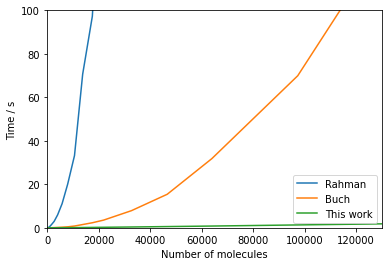

In [7]:
from matplotlib import pyplot as plt


buch = np.array(buch)
gen = np.array(gen)
rahman = np.array(rahman)


fig1, ax = plt.subplots()

# ax.set_aspect('square') #, adjustable='box')

plt.plot(rahman[:, 0], rahman[:, 1], label="Rahman")
plt.plot(buch[:, 0], buch[:, 1], label="Buch")
plt.plot(gen[:, 0], gen[:, 1], label="This work")
plt.xlim(0, 130000)
plt.legend()
plt.xlabel("Number of molecules")
plt.ylabel("Time / s")
plt.ylim(0, 100)
plt.show()

fig1.savefig("benchmark.pdf")

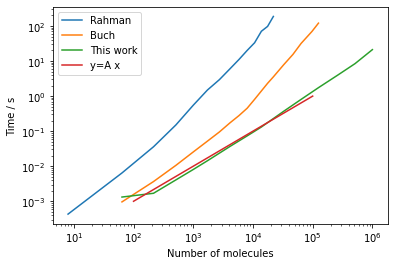

In [8]:
fig1, ax = plt.subplots()

lin = np.linspace(1e2, 1e5, 100)
plt.loglog(rahman[:, 0], rahman[:, 1], label="Rahman")
plt.loglog(buch[:, 0], buch[:, 1], label="Buch")
plt.loglog(gen[:, 0], gen[:, 1], label="This work")
plt.loglog(lin, lin*1e-5, label=r"y=A x")
plt.legend()
plt.xlabel("Number of molecules")
plt.ylabel("Time / s")

fig1.savefig("benchmark-loglog.pdf")


128


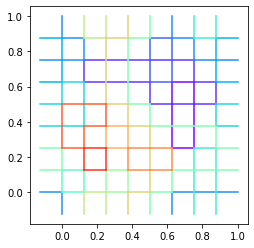

<ipython-input-9-f40769049690>:54: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig1.savefig("map.pdf", bbox='tight')


In [9]:
# for TOC graphics

from matplotlib import pyplot as plt


# make a 2D 6x6 ice.
def draw_cycle(cycle, pos, N, col):
    threshold = 1.1/N**2
    cm = plt.get_cmap('rainbow')
    for i in range(len(cycle)):
        a = cycle[i-1]
        b = cycle[i]
        va = pos[a]
        vb = pos[b]
        d = vb - va
        if d@d > threshold:
            d -= np.floor(d+0.5)
            seg = np.vstack([vb-d, vb])
            plt.plot(seg[:, 0], seg[:, 1], color=cm(col))
        seg = np.vstack([va, va+d])
        plt.plot(seg[:, 0], seg[:, 1], color=cm(col))


N = 8
X = np.arange(N)
Y = np.arange(N)
X, Y = np.meshgrid(X, Y)
X = X.reshape(N * N)
Y = Y.reshape(N * N)
pos = np.vstack([X, Y]).T / N  # fractional coordinate
g = nx.Graph()
for a in range(N*N):
    for b in range(a):
        d = pos[a] - pos[b]
        d -= np.floor(d+0.5)
        if (d@d)*N*N < 1.1:
            g.add_edge(a, b)

print(g.number_of_edges())


fig1, ax = plt.subplots()

cycles = []
dd = nx.DiGraph()
for cycle in tileByCycles(g):
    cycles.append(cycle)

for i, cycle in enumerate(cycles):
    draw_cycle(cycle, pos, N, i/len(cycles))

ax.set_aspect('equal', adjustable='box')
plt.show()
fig1.savefig("map.pdf", bbox='tight')

In [14]:
!pip install tilecycles

  Created wheel for tilecycles: filename=TileCycles-0.1.3-cp37-cp37m-linux_x86_64.whl size=97017 sha256=b1270a7012b4308d528f6848dd1d40b4d5bb4683ad680da36fffe367b6b33796
  Stored in directory: /root/.cache/pip/wheels/92/b8/e1/1d9df05efa5dffd9e7e1b3650a2844e857e5fdd1dfa245cdbc
Successfully built tilecycles


In [ ]:
# C++ implementation

import tilecycles as tc
import numpy as np

lattice = Lattice("1c")
formatter = Format("raw", stage=(2,))  # generates an undirected graph
water = Molecule("spce")

seed = 1111

cpp = []
for NN in range(4, 100):
    N = int(2**(NN/3))
    raw = GenIce(lattice, rep=[N, N, N]).generate_ice(water, formatter)
    g0 = raw['graph']
    Nnode = g0.number_of_nodes()

    pairs = np.array([(i, j) for i, j in g0.edges()], dtype=np.int32)

    delta = 0.0
    Nrep = 0
    while delta < maxAccum and Nrep < maxRepeat:
        now = time.time()
        dd = nx.DiGraph()
        for cycle in tc.tile(pairs, Nnode, seed):
            nx.add_cycle(dd, cycle)
        delta += time.time() - now
        Nrep += 1
    delta /= Nrep
    cpp.append([Nnode, delta, Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(dd, Nnode)
    if Nnode >= maxNode:
        break

64 molecules 0.00013041257858276367 s avg. 100 reps.
216 molecules 0.00043094635009765625 s avg. 100 reps.
512 molecules 0.0010037732124328614 s avg. 100 reps.
1000 molecules 0.0019905233383178712 s avg. 100 reps.
1728 molecules 0.0033107757568359374 s avg. 100 reps.
4096 molecules 0.00972919464111328 s avg. 100 reps.
8000 molecules 0.029241757392883302 s avg. 100 reps.
13824 molecules 0.0573698902130127 s avg. 100 reps.
32768 molecules 0.15115628480911256 s avg. 100 reps.
64000 molecules 0.3217358405773456 s avg. 78 reps.
125000 molecules 0.6451614453242376 s avg. 39 reps.
262144 molecules 1.4254716767205133 s avg. 18 reps.
512000 molecules 2.9338805145687528 s avg. 9 reps.


The C++ implementation is not quite fast because the data conversion between python always take a linear time against the system size.

In [ ]:
from matplotlib import pyplot as plt


gen = np.array(gen)
cpp = np.array(cpp)


fig1, ax = plt.subplots()

lin = np.linspace(1e2, 1e5, 100)
plt.loglog(gen[:, 0], gen[:, 1], label="Python")
plt.loglog(cpp[:, 0], cpp[:, 1], label="C++")

plt.loglog(lin, lin*1e-5, label=r"y=A x")
plt.legend()
plt.xlabel("Number of molecules")
plt.ylabel("Time / s")

fig1.savefig("benchmark-cp-loglog.pdf")

# C++ is four times faster than python,
# but Python is fast enough...

## 検定

生成した氷の構造が十分にランダムであるかどうかを確認するために、サイクルを構成する水素結合の向きの統計をとる。

氷の結晶構造はさまざまなサイズのirreducible ringsで構成されている。氷Iは6員環のみで構成されている。アイスルールを満たすネットワークに含まれる1つの6員環に注目すると、それを構成する水素結合の配向パターンには統計的な特徴がある。ここでは計算を簡単にするために次のようなBethe tree 近似を導入する。ある4-connectedな無限無向グラフ$g$が、6-cycleを1つだけもち、ほかにはサイクルを持たないものとする。このグラフ$g$にアイスルールを導入して有向グラフに変換した時、6-cycleに沿った辺の配向パターンの分布は表1のようになる。(誰かすでにやってそうなものだ。Stillinger?)

*Table 1 アイスルールを満たす有向グラフの六員環の配向パターンと、Bethe tree近似による出現確率*

| pattern| probability|
|------|--------|
|→→→→→→| 64/365 |
|→→→→→←| 96/365 |
|→→→→←←| 96/365 |
|→→→←→←| 24/365 |
|→→→←←←| 48/365 |
|→→←→→←| 12/365 |
|→→←→←←| 24/365 |
|→←→←→←|  1/365 |

現実の氷には無数の六員環が含まれているが、均質にランダムな水素無秩序氷では、上の分布に極めて近い分布が得られる。そこで、表1の分布と、生成した氷構造での配向パターンの分布を比較し、それらの分布の間のKullback-Leibler divergence $d_{KL}$を、氷構造の均質さの尺度とみなす。均質にランダムな水素無秩序氷では、$d_{KL}$は0に近付くが、配向パターンに偏りがあると、より大きな値になる。

Rahmanらのアルゴリズムと、Buchらのアルゴリズムはどちらも収束的なアルゴリズムで、計算サイクルを増やすほど均質な分布に近付く。Rahmanらのアルゴリズムに関しては、初期配置を氷XI構造とする。また、Buchのアルゴリズムでは、初期配置はice ruleを満たさない完全ランダムな有向グラフとする。そして、ステップを重ねるごとに、上の分布にどのように近接するかを観察する。


## Test

To check whether the structure of the generated ice is sufficiently random, we take the statistics of the orientation of the hydrogen bonds that make up the cycle.

The crystal structure of ice consists of irreducible rings of various sizes. Ice I consists of only six-membered rings. If we focus on a single six-membered ring in the network that satisfies the ice rules, the orientation pattern of the hydrogen bonds that make up the ring has a statistical characteristic. To simplify the calculation, we introduce the following Bethe tree approximation. Suppose that a 4-connected infinite undirected graph $g$ has only one 6-cycle and no other cycles. When this graph $g$ is transformed into a directed graph by introducing the ice rules, the distribution of  edge orientation patterns along the 6-cycle is as shown in Table 1.

*Table 1 Orientation patterns of six-membered rings in directed graphs satisfying the ice rules and their probability of occurrence using the Bethe tree approximation*.

| pattern| probability|
|------|--------|
|→→→→→→| 64/365 |
|→→→→→←| 96/365 |
|→→→→←←| 96/365 |
|→→→←→←| 24/365 |
|→→→←←←| 48/365 |
|→→←→→←| 12/365 |
|→→←→←←| 24/365 |
|→←→←→←|  1/365 |

Although real ice contains innumerable six-membered rings, homogeneously random hydrogen-disordered ice yields a distribution very close to the above one. Therefore, we compare the distributions in Table 1 with the distributions of the orientation patterns in the generated ice structure, and consider the Kullback-Leibler divergence $d_{KL}$ between these distributions as a measure of the homogeneity of the ice structure. For homogeneously random hydrogen-disordered ice, $d_{KL}$ approaches zero, while biases in the orientation pattern lead to larger values.

Both Rahman et al.'s and Buch et al.'s algorithms are convergent algorithms, approaching a homogeneous distribution with increasing number of computational cycles. For Rahman et al.'s algorithm, we choose the ice XI structure as the initial configuration. For Buch's algorithm, the initial configuration is a completely random directed graph that does not satisfy the ice rules. Then, with each step, we observe how it approaches the distribution above.

In [15]:
# Taken from GenIce/_ringstat.py
from genice2.formats._ringstat import probabilities, orientations, encode


def KLdiv(d, pos):
    graph = nx.Graph(d)  # undirected
    prob = probabilities(6)
    stat = defaultdict(int)

    for ring in cycles_iter(graph, 6,  pos=pos):
        ori = orientations(ring, d)
        c   = encode(ori)
        n   = len(ring)
        stat[c] += 1

    #size code code(binary) Approx. Stat.
    denom = 0
    for c in stat:
        denom += stat[c]
    dKL = 0.0
    for c in prob:
        q = stat[c]/denom
        p = prob[c]
        if q > 0.0:
            dKL += q*(log(q) - log(p))
    dKL /= log(2.0)  #bit
    return dKL

In [47]:
# Rahman's

lattice = Lattice("11")
formatter = Format("raw", stage=(1,3,))
water = Molecule("spce")

N = 8
raw = GenIce(lattice, rep=[N, N, N]).generate_ice(water, formatter)
d = nx.DiGraph(raw['digraph'].edges())
Nnode = d.number_of_nodes()
rpos = raw['reppositions']

# footprint
g = nx.Graph(d)

steps = 0
watch = 1
rahman_conv = []
while g.number_of_edges() > 0:
    steps += 1
    if watch == steps:
        # ring stat
        dKL = KLdiv(d, rpos)
        print(steps, dKL)
        rahman_conv.append([steps, dKL])
        # next watch interval
        watch += 100  # watch

    cycle = six(d, d.number_of_nodes())
    invertCycle(d, cycle, g)

dKL = KLdiv(d, rpos)
print(steps, dKL)
rahman_conv.append([steps, dKL])


1 0.8230307782265128
101 0.46683523667930915
201 0.2870459895577991
301 0.16959492265426093
401 0.120607158643624
501 0.0863366204624626
601 0.05969701766662183
701 0.04469211101361994
801 0.0324634997947819
901 0.019914520862471388
1001 0.01483859709309217
1101 0.011018126378635367
1201 0.010015569667034686
1301 0.008673652414289546
1401 0.006812642375119498
1501 0.005007804135077274
1601 0.004421655833669552
1701 0.0027397732428371515
1801 0.0021014292517241456
1901 0.002251944910601663
2001 0.001837493302079593
2101 0.0012832981142612274
2201 0.0017067981629903316
2301 0.0021939435718139767
2401 0.001787351073828499
2501 0.001453351736270308
2601 0.000916636574024932
2701 0.0006775658043458106
2801 0.0006510131425695527
2901 0.00039923155478159566
3001 0.0005021080058194804
3101 0.0004937518204501783
3201 0.0004719695558261731
3301 0.0007660393205576534
3401 0.0005295642259018764
3501 0.000324835322550262
3601 0.00039907673001252076
3701 0.0003374341923117791
3801 0.0002266595015183

KeyboardInterrupt: 

In [46]:
# Buch's

buch_conv = []

def migrate2(d, excess):
    """
    excess is a set of nodes having more than two outgoing edges
    """
    steps = 0
    watch = 1
    while len(excess) > 0:
        steps += 1
        if watch <= steps:
            # ring stat
            dKL = KLdiv(d, rpos)
            print(steps, dKL)
            buch_conv.append([steps, dKL])
            # next watch interval
            watch += 1000  # watch / 2

        head = random.choice(list(excess))
        nexts = list(d.successors(head))
        next = random.choice(nexts)
        d.remove_edge(head, next)
        d.add_edge(next, head)
        # if head's outgoing order was three
        if len(nexts) == 3:
            # remove from the excess list
            excess.remove(head)
        # if next's outgoing orderis three
        if d.out_degree(next) == 3:
            # it becomes a new excess
            excess.add(next)
    dKL = KLdiv(d, rpos)
    print(steps, dKL)
    buch_conv.append([steps, dKL])


lattice = Lattice("1h")
formatter = Format("raw", stage=(1,2,))  # generates an undirected graph
water = Molecule("spce")


N = 8
raw = GenIce(lattice, rep=[N, N, N]).generate_ice(water, formatter)
g = raw['graph']
rpos = raw['reppositions']
Nnode = g.number_of_nodes()

dd = nx.DiGraph()
for a, b in g.edges():
    if random.randint(0, 1) == 1:
        dd.add_edge(a, b)
    else:
        dd.add_edge(b, a)

migrate2(dd, set([x for x in dd.nodes if dd.out_degree(x) > 2]))


1 0.49849786970104853
1001 0.3514532074724364
2001 0.24442242069908862
3001 0.17926997378358023
4001 0.13369107225880802
5001 0.098626190197658
6001 0.0739823828469744
7001 0.05475108360157109
8001 0.04225702640686071
9001 0.034042103293595534
10001 0.026932279303484255
11001 0.021401898625665536
12001 0.01662531440293121
13001 0.012466214427154136
14001 0.010690352869881724
15001 0.008508649145552804
16001 0.0074239357264809765
17001 0.006171603567587445
18001 0.0052798299873485065
19001 0.004534286321251155
20001 0.0043431187897710185
21001 0.003729460409414698
22001 0.003296792864725474
23001 0.002635434262261646
24001 0.002574606214101003
25001 0.0020509841244979754
26001 0.0021574137267309063
27001 0.001833664482201879
28001 0.0014571915350640192
29001 0.0013014494477027734
30001 0.0009479473235550179
31001 0.0010804361120841455
32001 0.0009481950393369475
33001 0.0008220471412784902
34001 0.0007594468726664843
35001 0.0006533682667337737
36001 0.0008336406416566394
37001 0.000753

In [29]:
# GenIce's

lattice = Lattice("1h")
formatter = Format("raw", stage=(1,2,))  # generates an undirected graph
water = Molecule("spce")
N=8
raw = GenIce(lattice, rep=[N, N, N]).generate_ice(water, formatter)
g = nx.Graph(raw['graph'])
print(raw)
rpos = raw['reppositions']

d = nx.DiGraph()
for cycle in tileByCycles(g):
    nx.add_cycle(d, cycle)

genice_dKL = KLdiv(d, rpos)
print(genice_dKL)


{'reppositions': array([[0.02115152, 0.03053264, 0.04660404],
       [0.08388937, 0.07665353, 0.01529109],
       [0.10480198, 0.0922079 , 0.04639721],
       ...,
       [0.9791171 , 0.88938525, 0.98396796],
       [0.97981791, 0.96752983, 0.98370598],
       [0.89615152, 0.90583763, 0.98391281]]), 'repcell': array([[6.25827101, 0.        , 0.        ],
       [0.        , 5.88285812, 0.        ],
       [0.        , 0.        , 7.22921481]]), 'repcagetype': None, 'repcagepos': None, 'cagetypes': None, 'dopants': {}, 'groups': defaultdict(<class 'dict'>, {}), 'filled_cages': set(), 'graph': <genice2.digraph.IceGraph object at 0x11dc28490>}
0.0005141507548805231


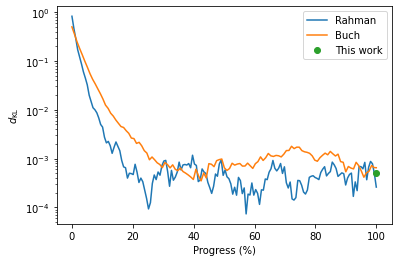

In [50]:
from matplotlib import pyplot as plt


buch_conv = np.array(buch_conv)
rahman_conv = np.array(rahman_conv)

fig1, ax = plt.subplots()

lin = np.linspace(1e2, 1e5, 100)
plt.plot(rahman_conv[:, 0] / rahman_conv[-1, 0]*100, rahman_conv[:, 1], label="Rahman")
plt.plot(buch_conv[:, 0] / buch_conv[-1, 0]*100, buch_conv[:, 1], label="Buch")
plt.plot(100, genice_dKL, 'o', label="This work")
plt.yscale('log')
plt.legend()
plt.xlabel("Progress (%)")
plt.ylabel(r"$d_\mathrm{KL}$")

fig1.savefig("ringstat-log.pdf")

In [18]:
!pip install pycodestyle flake8 pycodestyle_magic

     |████████████████████████████████| 51kB 2.5MB/s 
     |████████████████████████████████| 81kB 3.9MB/s 
     |████████████████████████████████| 71kB 4.3MB/s 


In [19]:
%load_ext pycodestyle_magic